In [1]:
%pylab inline
from __future__ import division

Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy import stats
np.random.seed(123456)

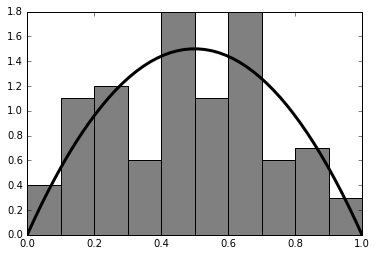

In [3]:
rv=stats.beta(2,2)
xi = np.linspace(0,1,50)
nbins = 10
binwidth = 1/nbins
n=  100
bins=np.arange(0,1+binwidth,binwidth)

d = rv.rvs(n)

fig,ax=subplots()
ax.plot(xi,rv.pdf(xi),lw=3.,color='k')

phat,_=histogram(d,bins,density=True)
ax.bar(bins[:-1],phat,width=binwidth,color='gray')
ax.axis(ymax=1.8);

In [4]:
ntrials=800
phat = np.zeros((nbins,ntrials))
for k in range(ntrials):
    d = rv.rvs(n)       
    phat[:,k],_=histogram(d,bins,density=True)

(-0.05, 1.05, 0.0, 2.5)

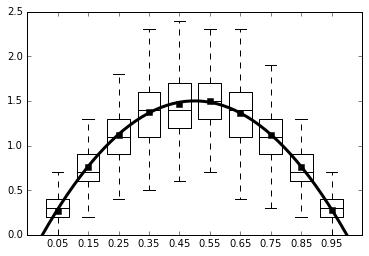

In [5]:
fig,ax=subplots()
ax.plot(xi,rv.pdf(xi),lw=3.,color='k')
ax.boxplot(phat.T,positions=bins[:-1]+binwidth/2,widths=.1*0.75,showmeans=True,
           medianprops={'color':'k'},boxprops={'color':'k'},meanprops={'markerfacecolor':'k'},
           showfliers=False,whiskerprops={'color':'k'});
ax.axis(xmin=-binwidth/2,xmax=1+binwidth/2)

In [6]:
def generate_samples(n,ntrials=500):
    phat = np.zeros((nbins,ntrials))
    for k in range(ntrials):
        d = rv.rvs(n)       
        phat[:,k],_=histogram(d,bins,density=True)   
    return phat
    
def draw_boxplots(ax,phat):
    black_color={'color':'k'}
    ax.plot(xi,rv.pdf(xi),lw=3.,color='k')
    ax.boxplot(phat.T,positions=bins[:-1]+binwidth/2,widths=binwidth*0.75,showmeans=True,
               medianprops=black_color,boxprops=black_color,meanprops={'markerfacecolor':'k'},
               showfliers=True,whiskerprops=black_color,flierprops={'color':'k','alpha':.3});
    ax.axis(xmin=-binwidth/2,xmax=1+binwidth/2)

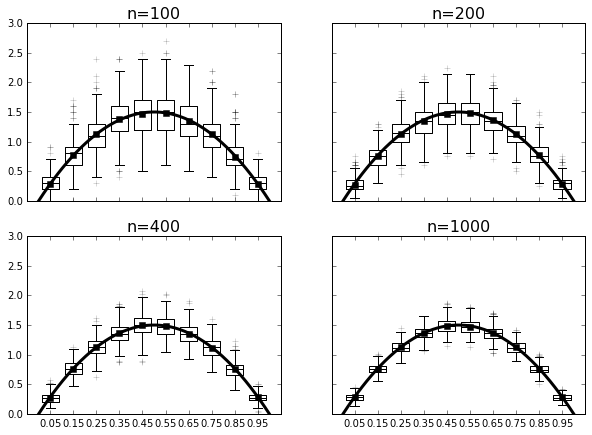

In [7]:
fig,axs=subplots(2,2,sharex=True,sharey=True)
fig.set_size_inches((10,7))
for ax,k in zip(axs.flat,[100,200,400,1000]):
    draw_boxplots(ax,generate_samples(k))
    ax.set_title('n=%d'%(k),fontsize=16)
    
# fig.savefig('../fig-statistics/nonparametric_001.png',dpi=120)

##  Kernel Density Estimation

In [8]:
gauss = lambda x: stats.norm(0,1).pdf(x)

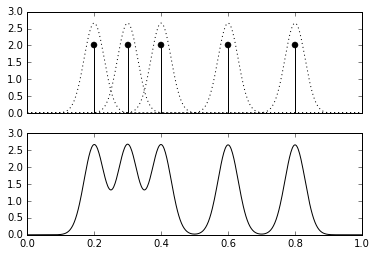

In [9]:
xi = np.linspace(0,1,500)
d = np.array([0.2,0.3,.4,.6,.8])
fig,axs = subplots(2,1,sharex=True)
ax = axs[0]
for i in d:
    ax.plot(xi,1/.03*gauss(abs(xi-i)/.03)/5,'k:')
ax.stem(d,d*0+2,linefmt='k-',markerfmt='ko')

axs[1].plot(xi,np.sum([(1/.03*gauss(abs(xi-i)/.03)/5) for i in d ],axis=0),'-k')
# axs[1].plot(xi,rv.pdf(xi),'k--')
# fig.savefig('../fig-statistics/nonparametric_002.png',dpi=120)

### Cross Validation

0.05 -1.13231859017
0.2 -1.13300210142
0.3 -1.0810329094


(0.0, 1.0, 0.0, 50)

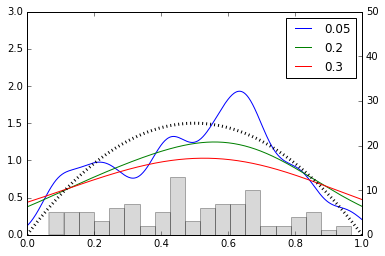

In [10]:
from sklearn.cross_validation import KFold, train_test_split
from sklearn.neighbors.kde import KernelDensity
from scipy.integrate import quad
np.random.seed(123456)
d = rv.rvs(n)[:,None]
train,test,_,_=train_test_split(d,d,test_size=0.5)

kdes=[KernelDensity(bandwidth=i).fit(train) for i in [.05,0.2,0.3]]
for i in kdes:
    f=lambda x: np.exp(i.score_samples(x))
    f2 = lambda x: f(x)**2
    print i.bandwidth,quad(f2,0,1)[0]-2*np.mean(f(test))
    plot(xi,f(xi[:,None]),label=str(i.bandwidth))
plot(xi,rv.pdf(xi),'k:',lw=3)
axis(ymax=3)
legend(loc=0)
ax=gca().twinx()
ax.hist(d,20,alpha=.3,color='gray')
ax.axis(ymax=50)

In [11]:
# using sklearn gridsearch
from sklearn import grid_search

class KernelDensityWrapper(KernelDensity):
    def predict(self,x):
        return np.exp(self.score_samples(x))
    def score(self,test):
        f = lambda x: self.predict(x)
        f2 = lambda x: f(x)**2
        return -(quad(f2,0,1)[0]-2*np.mean(f(test)))
    
kde=KernelDensityWrapper(bandwidth=.1)
kde.fit(d)
kde.score(test)

1.2106193427090668

{'bandwidth': 0.17333333333333334}


[mean: 0.60758, std: 0.07695, params: {'bandwidth': 0.01},
 mean: 1.06325, std: 0.03866, params: {'bandwidth': 0.064444444444444443},
 mean: 1.11859, std: 0.02093, params: {'bandwidth': 0.11888888888888888},
 mean: 1.13187, std: 0.01397, params: {'bandwidth': 0.17333333333333334},
 mean: 1.12007, std: 0.01043, params: {'bandwidth': 0.22777777777777777},
 mean: 1.09186, std: 0.00794, params: {'bandwidth': 0.28222222222222221},
 mean: 1.05391, std: 0.00601, params: {'bandwidth': 0.33666666666666667},
 mean: 1.01126, std: 0.00453, params: {'bandwidth': 0.39111111111111108},
 mean: 0.96717, std: 0.00341, params: {'bandwidth': 0.44555555555555554},
 mean: 0.92355, std: 0.00257, params: {'bandwidth': 0.5}]

(array([ 10.,   8.,  13.,   7.,  16.,  13.,  17.,   4.,   9.,   3.]),
 array([ 0.06484878,  0.15509664,  0.24534449,  0.33559235,  0.42584021,
         0.51608807,  0.60633592,  0.69658378,  0.78683164,  0.8770795 ,
         0.96732736]),
 <a list of 10 Patch objects>)

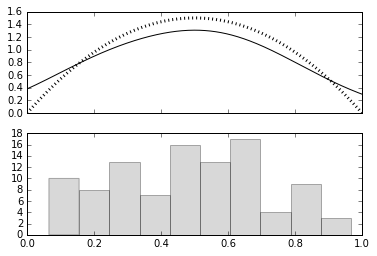

In [12]:
params = {'bandwidth':linspace(0.01,0.5,10)}
clf = grid_search.GridSearchCV(KernelDensityWrapper(), param_grid=params,cv=2)
clf.fit(d)
print clf.best_params_
display(clf.grid_scores_)
fig,axs=subplots(2,1,sharex=True)

axs[0].plot(xi,rv.pdf(xi),'k:',lw=3)
axs[0].plot(xi,clf.best_estimator_.predict(xi[:,None]),'k-')
axs[1].hist(d,alpha=.3,color='gray')

{'bandwidth': 0.2231977859638383}


[mean: 1.05856, std: 0.00621, params: {'bandwidth': 0.33045584808921374},
 mean: 0.94327, std: 0.00292, params: {'bandwidth': 0.4752162590854183},
 mean: 0.84745, std: 0.00156, params: {'bandwidth': 0.6004333702398068},
 mean: 1.12179, std: 0.01067, params: {'bandwidth': 0.2231977859638383},
 mean: 0.67318, std: 0.00045, params: {'bandwidth': 0.885213912257439},
 mean: 0.79702, std: 0.00111, params: {'bandwidth': 0.673172684264422},
 mean: 1.05101, std: 0.00589, params: {'bandwidth': 0.34050675589140833},
 mean: 0.65258, std: 0.00039, params: {'bandwidth': 0.9268063940330119},
 mean: 0.65594, std: 0.00040, params: {'bandwidth': 0.9198597459015143},
 mean: 0.90583, std: 0.00229, params: {'bandwidth': 0.5226189344092694}]

(array([ 10.,   8.,  13.,   7.,  16.,  13.,  17.,   4.,   9.,   3.]),
 array([ 0.06484878,  0.15509664,  0.24534449,  0.33559235,  0.42584021,
         0.51608807,  0.60633592,  0.69658378,  0.78683164,  0.8770795 ,
         0.96732736]),
 <a list of 10 Patch objects>)

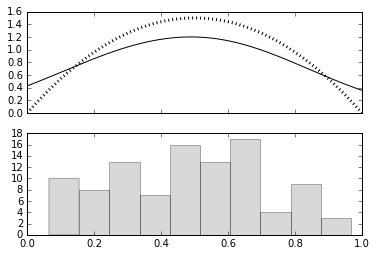

In [13]:
params = {'bandwidth':stats.uniform(0.01,.99)}
clf = grid_search.RandomizedSearchCV(KernelDensityWrapper(), param_distributions=params,cv=2,)
clf.fit(d)
print clf.best_params_
display(clf.grid_scores_)
fig,axs=subplots(2,1,sharex=True)

axs[0].plot(xi,rv.pdf(xi),'k:',lw=3)
axs[0].plot(xi,clf.best_estimator_.predict(xi[:,None]),'k-')
axs[1].hist(d,alpha=.3,color='gray')

In [14]:
%qtconsole

D:\Miniconda64\lib\site-packages\IPython\parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


## Nearest Neighbor Regression

In [15]:
xi = np.linspace(0,1,100)[:,None]
xin = np.sort(np.random.rand(50))[:,None]
xin = np.linspace(0,1,12)[:,None]

f0 = 1 # init frequency
BW = 5
y = cos(2*pi*(f0*xin+(BW/2.0)*xin**2))

from sklearn.neighbors import KNeighborsRegressor
knr=KNeighborsRegressor(2) 
_=knr.fit(xin,y)

D:\Miniconda64\lib\site-packages\matplotlib\figure.py:1718: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


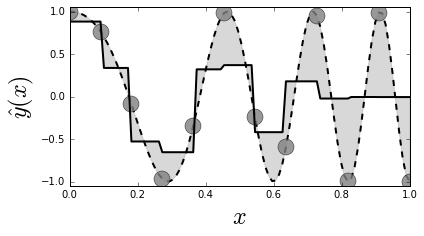

In [16]:
fig,ax=subplots()
yi = cos(2*pi*(f0*xi+(BW/2.0)*xi**2))
_=ax.plot(xi,yi,'k--',lw=2)
_=ax.plot(xin,y,'ko',lw=2,ms=16,color='gray',alpha=.8)
_=ax.fill_between(xi.flat,yi.flat,knr.predict(xi).flat,color='gray',alpha=.3)
_=ax.plot(xi,knr.predict(xi),'k-',lw=2)
_=ax.set_aspect(1/4.)
_=ax.axis(ymax=1.05,ymin=-1.05)
_=ax.set_xlabel(r'$x$',fontsize=24)
_=ax.set_ylabel(r'$\hat{y}(x)$',fontsize=24)
fig.set_tight_layout(True)
# fig.savefig('../fig-statistics/nonparametric_004.png')

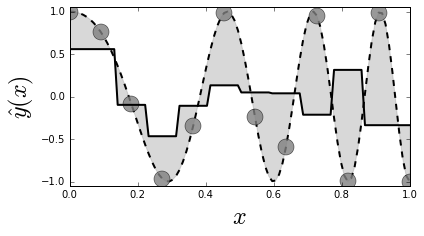

In [17]:
# 013 ------------------------------------------------------------
knr=KNeighborsRegressor(3) 
knr.fit(xin,y)

# 014 ------------------------------------------------------------
fig,ax=subplots()
_=ax.plot(xi,yi,'k--',lw=2)
_=ax.plot(xin,y,'ko',lw=2,ms=16,color='gray',alpha=.8)
_=ax.plot(xi,knr.predict(xi),'k-',lw=2)
_=ax.fill_between(xi.flat,yi.flat,knr.predict(xi).flat,color='gray',alpha=.3)
_=ax.set_aspect(1/4.)
_=ax.axis(ymax=1.05,ymin=-1.05)
_=ax.set_xlabel(r'$x$',fontsize=24)
_=ax.set_ylabel(r'$\hat{y}(x)$',fontsize=24)
fig.set_tight_layout(True)


In [18]:
# leave one out cross validation 
from sklearn.cross_validation import LeaveOneOut
loo=LeaveOneOut(len(xin))
knr=KNeighborsRegressor(2) 

o=[]
for train_index, test_index in loo:
    knr.fit(xin[train_index],y[train_index])
    o.append((knr.predict(xi[test_index]) - y[test_index])**2)

print np.mean(o)
knr.fit(xin,y)
print mean((knr.predict(xi) - yi)**2)

1.3009920688
0.230205276389


In [19]:
oo=[]
knr=KNeighborsRegressor(2) 

for i in range(100):
    xin = np.sort(np.random.rand(50))[:,None]
    y = cos(2*pi*(f0*xin+(BW/2.0)*xin**2))
    o=[]
    for train_index, test_index in loo:
        knr.fit(xin[train_index],y[train_index]);
        o.append((knr.predict(xi[test_index]) - y[test_index])**2)
    knr.fit(xin,y)
    oo.append((np.mean(o), mean((knr.predict(xi) - yi)**2)))

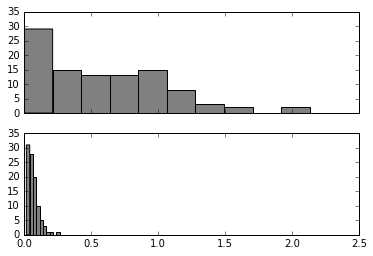

In [20]:
oo=np.array(oo);
fig,axs=subplots(2,1,sharex=True,sharey=True);
_=axs[0].hist(oo[:,0],color='gray');
_=axs[1].hist(oo[:,1],color='gray');

### Use Transform matrix

In [21]:
knr=KNeighborsRegressor(3) 
_=knr.fit(xin,y)
t=(knr.kneighbors_graph(xin)).todense()/knr.n_neighbors

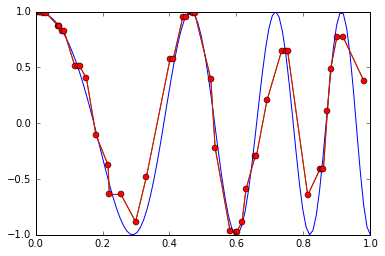

In [22]:
plot(xi,yi,xin,knr.predict(xin),xin,t*y,'o-')

In [23]:
# leave one out cross validation 
loo=LeaveOneOut(len(xin))

o=[]
for train_index, test_index in loo:
    knr.fit(xin[train_index],y[train_index])
    o.append((knr.predict(xi[test_index])-y[test_index])**2)

print np.mean(o)

0.718546238929


In [24]:
_=knr.fit(xin,y)
mean((y-knr.predict(xin))**2)/(1-1/knr.n_neighbors)**2

0.10380767261688832

In [25]:
train_index, test_index= list(loo)[8]
ki=KNeighborsRegressor(3) 
ki.fit(xin[train_index],y[train_index])
print ki.kneighbors(xin[test_index])[1]
print y[train_index][[6,7,8]].mean()
print ki.predict(xi[test_index])

[[8 7 6]]
0.844650727137
[[ 0.84465073]]


In [26]:
print knr.kneighbors(xin[test_index])[1]
print knr.predict(xin[test_index])
print y[[8,9,7]].mean()

[[8 9 7]]
[[ 0.82988862]]
0.829888616351


In [27]:
quad(lambda i:(knr.predict(i)-cos(2*pi*(f0*i+(BW/2.0)*i**2)))**2,0,1)[0]

D:\Miniconda64\lib\site-packages\scipy\integrate\quadpack.py:352: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


0.0901197894955828

In [28]:
mean(o)

0.71854623892929337

## Kernel Regression

In [29]:
%run -i src-statistics/kernel_regression.py

ERROR: File `u'src-statistics/kernel_regression.py'` not found.


In [30]:
xin = np.linspace(0,1,20)[:,None]
y = cos(2*pi*(f0*xin+(BW/2.0)*xin**2))

kr = KernelRegression(gamma=np.linspace(6000,7000,500))
kr.fit(xin,y.flatten())
knr.fit(xin,y)

fig,ax=subplots()
fig.set_size_inches((12,4))
kr.predict(xi)
ax.plot(xi,kr.predict(xi),'k-',label='kernel',lw=3)
ax.plot(xin,y,'ok',lw=3)
ax.plot(xi,yi,'--',color='gray',label='chirp')
ax.plot(xi,knr.predict(xi),label='nearest')
ax.axis(ymax=1.1,ymin=-1.1)
_=ax.set_aspect(1/4.)
_=ax.axis(ymax=1.05,ymin=-1.05)
_=ax.set_xlabel(r'$x$',fontsize=24)
ax.legend(loc=0)

NameError: name 'KernelRegression' is not defined